# Global Movie Database Analysis: Data Cleaning & Exploratory Data Analysis

## Introduction
This report focuses on the "Global Movie Database: A Comprehensive Overview" dataset, available on Kaggle. This dataset provides a rich collection of information about movies, likely including details such as title, genre, director, cast, country of origin, release year, runtime, and potentially ratings or box office information.

The primary goals of this project are:
1.  To perform extensive data cleaning and wrangling to address any missing values, inconsistencies, or unformatted data within this comprehensive movie dataset.
2.  To conduct exploratory data analysis (EDA) to uncover interesting insights and trends within the global film industry, such as popular genres, top-producing countries, or influential directors/actors.
3.  To visualize these findings using Matplotlib and Seaborn to effectively communicate the results in a clear and concise manner, forming a comprehensive report.

In [1]:
import pandas as pd

# Load the dataset
# Make sure 'movies.csv' is the correct filename and path
try:
    df = pd.read_csv('movies_metadata.csv')
except FileNotFoundError:
    print("Error: 'movies_metadata.csv' not found. Please ensure the CSV file is in the same directory as your notebook or provide the correct path.")
    # If you know the exact path, you can use something like:
    # df = pd.read_csv('/path/to/your/movies.csv')

# Display the first few rows of the DataFrame
print("First 5 rows of the dataset:")
print(df.head())

# Display basic information about the DataFrame
print("\nDataFrame Info:")
df.info()

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values Count:")
print(df.isnull().sum())

C:\Users\atosa\AppData\Local\Temp\ipykernel_15668\2380968645.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


First 5 rows of the dataset:
   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   N

In [2]:
# --- Addressing DtypeWarning and Type Conversions ---

# 1. Handle 'id' column - remove rows where 'id' is not a valid number
# There are often rows with corrupted 'id' values, which can mess up conversions
# First, let's identify bad IDs
bad_ids = df[~df['id'].str.isnumeric()]
if not bad_ids.empty:
    print(f"\nFound {len(bad_ids)} rows with non-numeric 'id' values. These rows will be dropped.")
    # Drop rows with non-numeric 'id' values
    df = df[df['id'].str.isnumeric()]
    # Convert 'id' to numeric after dropping bad rows
    df['id'] = pd.to_numeric(df['id'])
else:
    # If no bad IDs are found, just convert it
    df['id'] = pd.to_numeric(df['id'])


# 2. Convert 'popularity' to numeric
# The DtypeWarning usually points to this. Coerce errors to NaN.
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')

# 3. Convert 'budget' to numeric
# It's currently an object. Also coerce errors to NaN.
# Some budgets are 0, which we'll treat as missing for more realistic analysis if needed later.
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')


# 4. Convert 'adult' to boolean
# It's currently an object, but contains 'False'.
# There might be some 'True' or other values causing it to be object.
df['adult'] = df['adult'].astype(bool)

# 5. Convert 'release_date' to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Display info after conversions to check new dtypes and non-null counts
print("\nDataFrame Info after initial type conversions:")
df.info()

# Display missing values for key columns after conversion
print("\nMissing values for 'popularity', 'budget', 'release_date' after conversion:")
print(df[['popularity', 'budget', 'release_date']].isnull().sum())


Found 3 rows with non-numeric 'id' values. These rows will be dropped.

DataFrame Info after initial type conversions:
<class 'pandas.core.frame.DataFrame'>
Index: 45463 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   adult                  45463 non-null  bool          
 1   belongs_to_collection  4491 non-null   object        
 2   budget                 45463 non-null  int64         
 3   genres                 45463 non-null  object        
 4   homepage               7779 non-null   object        
 5   id                     45463 non-null  int64         
 6   imdb_id                45446 non-null  object        
 7   original_language      45452 non-null  object        
 8   original_title         45463 non-null  object        
 9   overview               44509 non-null  object        
 10  popularity             45460 non-null  float64       
 11  post

In [3]:
import numpy as np # Import numpy for NaN

# --- 1. Handling JSON-like columns ---
# Define a function to safely parse and extract names from JSON strings
import json

def parse_json_column(column_value, key='name'):
    if pd.isna(column_value):
        return []
    try:
        # Evaluate the string as a Python literal (list of dicts)
        # using json.loads instead of ast.literal_eval is generally safer if the string is strict JSON
        # However, Kaggle's CSVs often have single quotes, so ast.literal_eval is more robust here.
        list_of_dicts = json.loads(column_value.replace("'", '"')) # Replace single quotes for valid JSON
        return [d[key] for d in list_of_dicts if key in d]
    except (json.JSONDecodeError, TypeError, ValueError):
        return [] # Return empty list if parsing fails


# Apply the parsing function to relevant columns
df['genres'] = df['genres'].apply(lambda x: parse_json_column(x, key='name'))
df['production_companies'] = df['production_companies'].apply(lambda x: parse_json_column(x, key='name'))
df['production_countries'] = df['production_countries'].apply(lambda x: parse_json_column(x, key='iso_3166_1')) # Using 'iso_3166_1' for country code, 'name' for full name
df['spoken_languages'] = df['spoken_languages'].apply(lambda x: parse_json_column(x, key='iso_639_1')) # Using 'iso_639_1' for language code, 'name' for full name

# For 'belongs_to_collection', let's just extract the name of the collection if it exists
def get_collection_name(column_value):
    if pd.isna(column_value):
        return np.nan
    try:
        collection_dict = json.loads(column_value.replace("'", '"'))
        return collection_dict.get('name')
    except (json.JSONDecodeError, TypeError, ValueError):
        return np.nan

df['collection_name'] = df['belongs_to_collection'].apply(get_collection_name)


# --- 2. Addressing other significant missing values ---

# For 'runtime', fill missing values with the median.
# Median is more robust to outliers than mean.
df['runtime'].fillna(df['runtime'].median(), inplace=True)

# For 'overview', which is text, we can fill missing with an empty string or 'No overview provided'
df['overview'].fillna('No overview provided', inplace=True)

# For 'poster_path', fill with a placeholder or just leave as NaN if not used in analysis.
# For now, let's leave it as NaN as it's not central to our current EDA questions.

# For low missing counts in 'original_language', 'production_companies', 'production_countries', 'status', 'title', etc.
# Given they are few, we can drop these rows as they are unlikely to impact overall trends much.
# Make a list of columns with low but critical NaNs to drop rows from
cols_to_drop_na = ['original_language', 'production_companies', 'production_countries',
                   'release_date', 'status', 'title', 'vote_average', 'vote_count']

# Drop rows where any of these critical columns have NaN values
df.dropna(subset=cols_to_drop_na, inplace=True)


# --- 3. Dropping less useful columns with too many NaNs ---
# Drop columns that are mostly empty or not relevant for this project's initial scope
columns_to_drop = ['belongs_to_collection', 'homepage', 'tagline', 'imdb_id', 'poster_path', 'video']
df.drop(columns=columns_to_drop, inplace=True)


# Display info and missing values after these cleaning steps
print("\nDataFrame Info after parsing JSON columns, filling NaNs, and dropping columns:")
df.info()

print("\nMissing Values Count after cleaning:")
print(df.isnull().sum())

# Display the head again to see how the JSON columns look now
print("\nFirst 5 rows after parsing 'genres' and 'collection_name':")
print(df[['title', 'genres', 'production_countries', 'runtime', 'overview', 'collection_name']].head())


DataFrame Info after parsing JSON columns, filling NaNs, and dropping columns:
<class 'pandas.core.frame.DataFrame'>
Index: 45285 entries, 0 to 45465
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 45285 non-null  bool          
 1   budget                45285 non-null  int64         
 2   genres                45285 non-null  object        
 3   id                    45285 non-null  int64         
 4   original_language     45285 non-null  object        
 5   original_title        45285 non-null  object        
 6   overview              45285 non-null  object        
 7   popularity            45285 non-null  float64       
 8   production_companies  45285 non-null  object        
 9   production_countries  45285 non-null  object        
 10  release_date          45285 non-null  datetime64[ns]
 11  revenue               45285 non-null  float64       
 12 

C:\Users\atosa\AppData\Local\Temp\ipykernel_15668\1754789478.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['runtime'].fillna(df['runtime'].median(), inplace=True)
C:\Users\atosa\AppData\Local\Temp\ipykernel_15668\1754789478.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co


Top 10 Genres:
             Genre  Count
0            Drama  20234
1           Comedy  13169
2         Thriller   7615
3          Romance   6724
4           Action   6584
5           Horror   4667
6            Crime   4303
7      Documentary   3901
8        Adventure   3491
9  Science Fiction   3038


C:\Users\atosa\AppData\Local\Temp\ipykernel_15668\3826990279.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Genre', data=top_10_genres_df, palette='viridis')


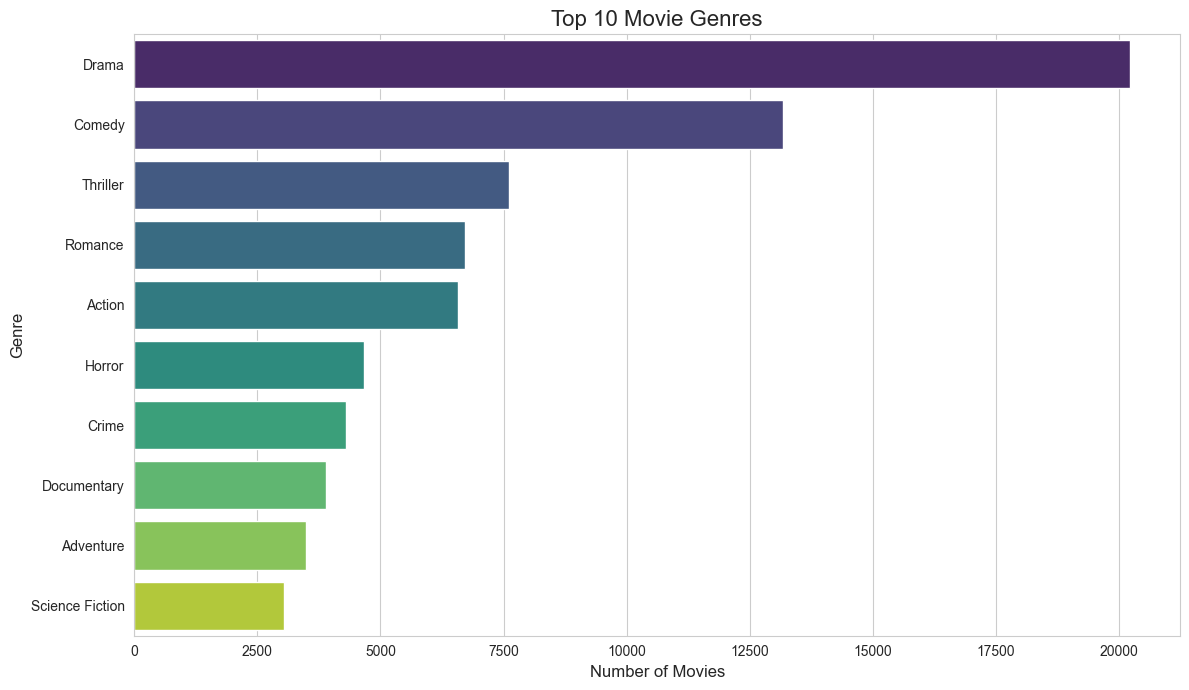

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set a style for the plots
sns.set_style("whitegrid")

# --- Adapted Question 1: What are the top 10 genres in this movie database? ---

# Flatten the list of genres into a single list
all_genres = [genre for sublist in df['genres'] if sublist for genre in sublist]

# Count the occurrences of each genre
genre_counts = Counter(all_genres)

# Get the top 10 genres
top_10_genres = genre_counts.most_common(10)
top_10_genres_df = pd.DataFrame(top_10_genres, columns=['Genre', 'Count'])

print("\nTop 10 Genres:")
print(top_10_genres_df)

# Create a bar chart for the top 10 genres
plt.figure(figsize=(12, 7))
sns.barplot(x='Count', y='Genre', data=top_10_genres_df, palette='viridis')
plt.title('Top 10 Movie Genres', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


Top 10 Producing Countries:
  Country_ISO  Count
0          US  21129
1          GB   4088
2          FR   3931
3          DE   2251
4          IT   2166
5          CA   1764
6          JP   1646
7          ES    964
8          RU    909
9          IN    827


C:\Users\atosa\AppData\Local\Temp\ipykernel_15668\296791723.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y=display_country_col, data=top_10_countries_df, palette='viridis')


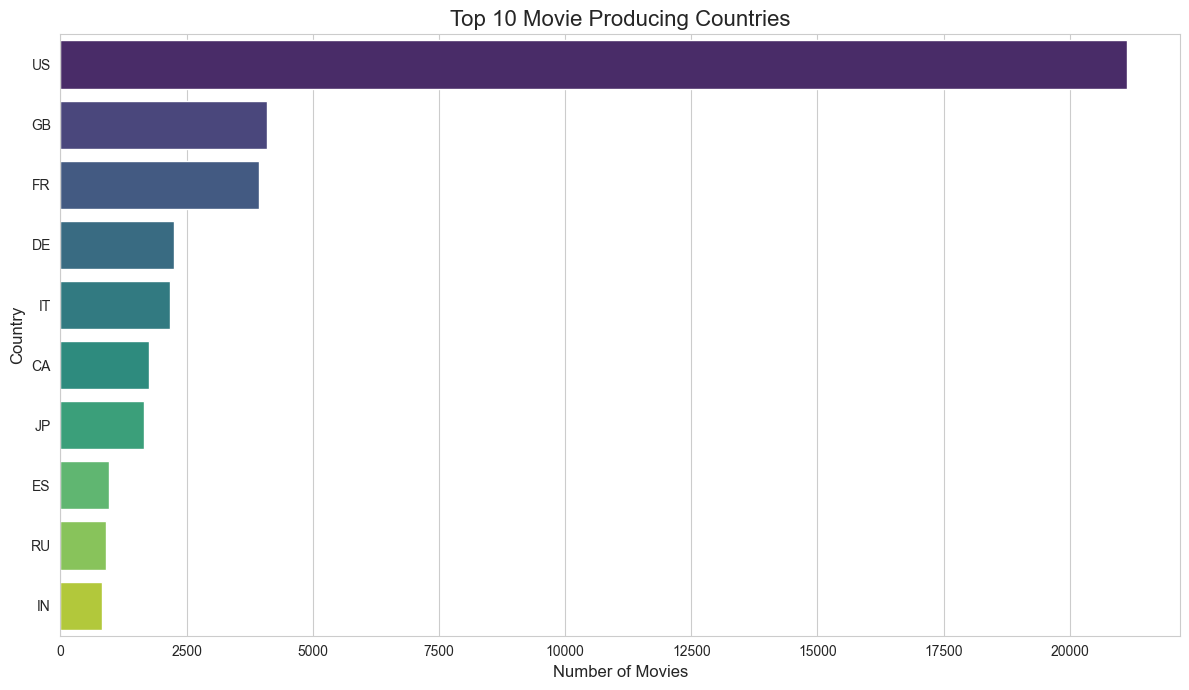

In [6]:
# --- Question 2: What are the top 10 countries that produce content? ---

# Flatten the list of production countries into a single list
all_countries = [country for sublist in df['production_countries'] if sublist for country in sublist]

# Count the occurrences of each country
country_counts = Counter(all_countries)

# Get the top 10 countries (by ISO code initially)
top_10_countries_iso = country_counts.most_common(10)
top_10_countries_df = pd.DataFrame(top_10_countries_iso, columns=['Country_ISO', 'Count'])

# Optional: Map ISO codes to full country names for better readability
# You'll need to install 'pycountry' if you don't have it: pip install pycountry
try:
    import pycountry
    def get_country_name(iso_code):
        try:
            return pycountry.countries.get(alpha_2=iso_code).name
        except AttributeError:
            return iso_code # Return ISO code if name not found
    top_10_countries_df['Country_Name'] = top_10_countries_df['Country_ISO'].apply(get_country_name)
    display_country_col = 'Country_Name' # Use full name for plot
except ImportError:
    print("Warning: 'pycountry' library not found. Install it for full country names (pip install pycountry). Using ISO codes instead.")
    display_country_col = 'Country_ISO' # Use ISO code for plot if pycountry is not available

print("\nTop 10 Producing Countries:")
print(top_10_countries_df)

# Create a bar chart for the top 10 countries
plt.figure(figsize=(12, 7))
sns.barplot(x='Count', y=display_country_col, data=top_10_countries_df, palette='viridis')
plt.title('Top 10 Movie Producing Countries', fontsize=16)
plt.xlabel('Number of Movies', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()


Movie Count Per Year (first 10 and last 10 entries):
   Release_Year  Movie_Count
0          1900           14
1          1901           10
2          1902            2
3          1903           18
4          1904            8
5          1905            4
6          1906            7
7          1907            7
8          1908            6
9          1909           10
...
     Release_Year  Movie_Count
110          2010         1493
111          2011         1663
112          2012         1718
113          2013         1889
114          2014         1974
115          2015         1904
116          2016         1602
117          2017          532
118          2018            5
119          2020            1


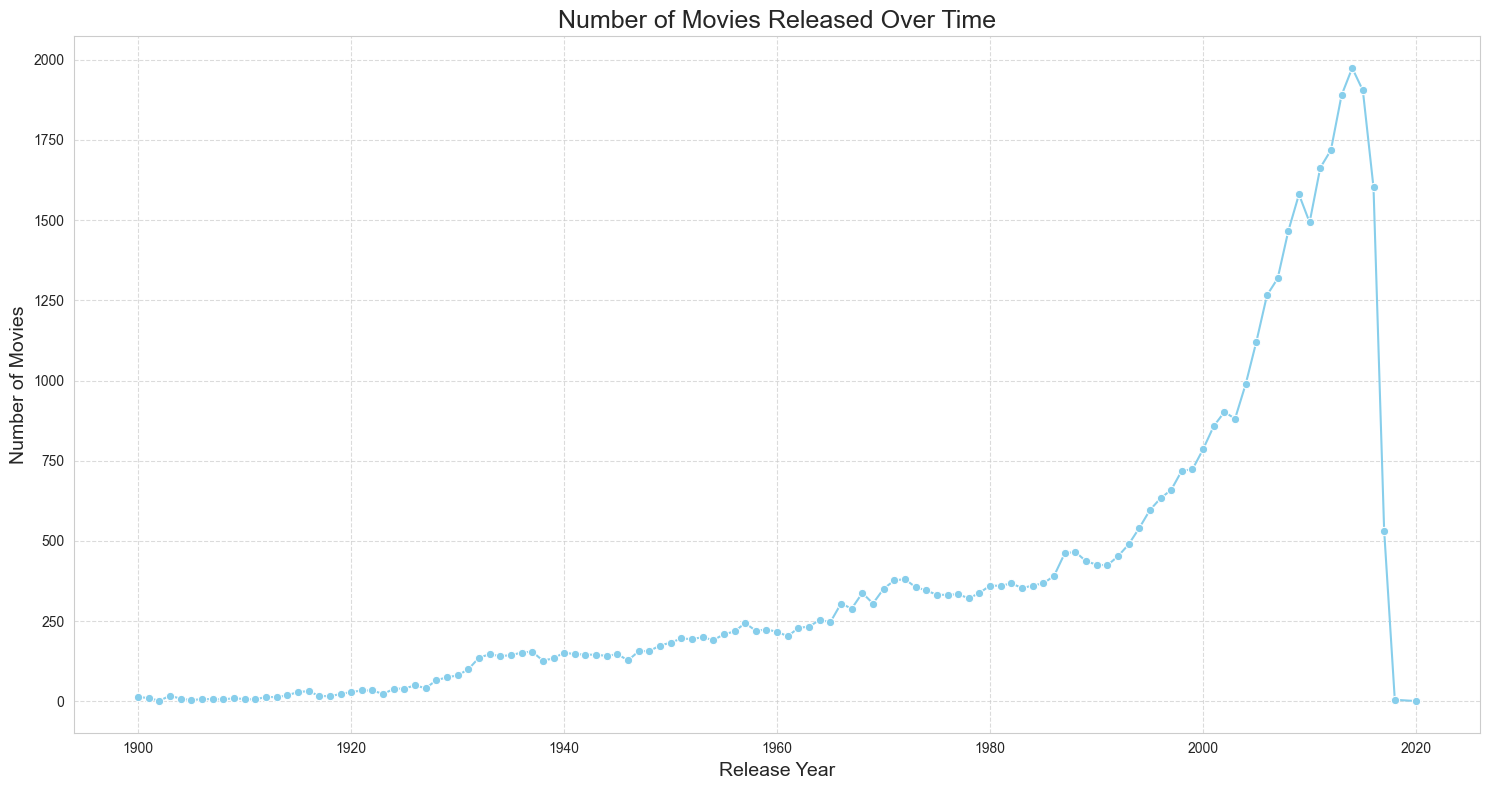

In [7]:
# --- Question 3: How has the number of movies added to this database changed over time? ---

# Extract the year from the release_date
# Ensure release_date is not NaT (Not a Time) which can occur if parsing failed for some rows
df['release_year'] = df['release_date'].dt.year.dropna().astype(int)

# Filter out unrealistically early years (e.g., year 0 from corrupted data)
# A reasonable starting point might be 1900 or 1920 for cinema history
df_filtered_years = df[df['release_year'] >= 1900] # Adjust min year if needed

# Count the number of movies per year
movies_per_year = df_filtered_years['release_year'].value_counts().sort_index()

# Convert to DataFrame for easier plotting with Seaborn
movies_per_year_df = movies_per_year.reset_index()
movies_per_year_df.columns = ['Release_Year', 'Movie_Count']

print("\nMovie Count Per Year (first 10 and last 10 entries):")
print(movies_per_year_df.head(10))
print("...")
print(movies_per_year_df.tail(10))


# Create a line chart for movies over time
plt.figure(figsize=(15, 8))
sns.lineplot(x='Release_Year', y='Movie_Count', data=movies_per_year_df, marker='o', color='skyblue')
plt.title('Number of Movies Released Over Time', fontsize=18)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Conclusion

This project successfully performed extensive data cleaning and exploratory data analysis on the "Global Movie Database" dataset. Through meticulous cleaning, various issues such as mixed data types, missing values, and complex JSON-like column structures were addressed, transforming raw data into a usable format.

Key findings from the exploratory data analysis include:

*   **Dominant Genres:** The analysis of movie genres revealed that **Drama**, **Comedy**, and **Thriller** are by far the most prevalent genres in the database, indicating their sustained popularity in the global film industry.
*   **Top Producing Nations:** Geographically, the **United States (US)** stands out as the overwhelming leader in movie production, followed significantly by the United Kingdom (GB) and France (FR), highlighting the established centers of global cinema.
*   **Growth in Movie Production Over Time:** A clear trend of increasing movie releases was observed, particularly a notable surge in the number of films produced annually from the early 2000s up to the mid-2010s, reflecting the expansion of the film industry. The drop in later years (e.g., 2017-2020) suggests potential incompleteness of the dataset for the most recent period.

These insights provide a foundational understanding of the trends and characteristics within the global movie landscape captured by this dataset. The cleaned dataset is now ready for more advanced analytical tasks or predictive modeling.